In [ ]:
# Install dependencies:
# !pip install -r requirements.txt

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import sxs
import spherical
import quaternionic

In [97]:
# Make sure downloaded data is cached:
# sxs.write_config(download=True, cache=True)

We'll use a simulation from the public SXS catalog of black-hole binary simulations:

In [135]:
simulation = sxs.load("SXS:BBH:1006/Lev/metadata.json")
waveform = sxs.load("SXS:BBH:1006/Lev/rhOverM", extrapolation_order=2)
horizons = sxs.load("SXS:BBH:1006/Lev/Horizons.h5")

Found the following files to load from the SXS catalog:
    SXS:BBH:1006v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1006v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1006v5/Lev3/Horizons.h5


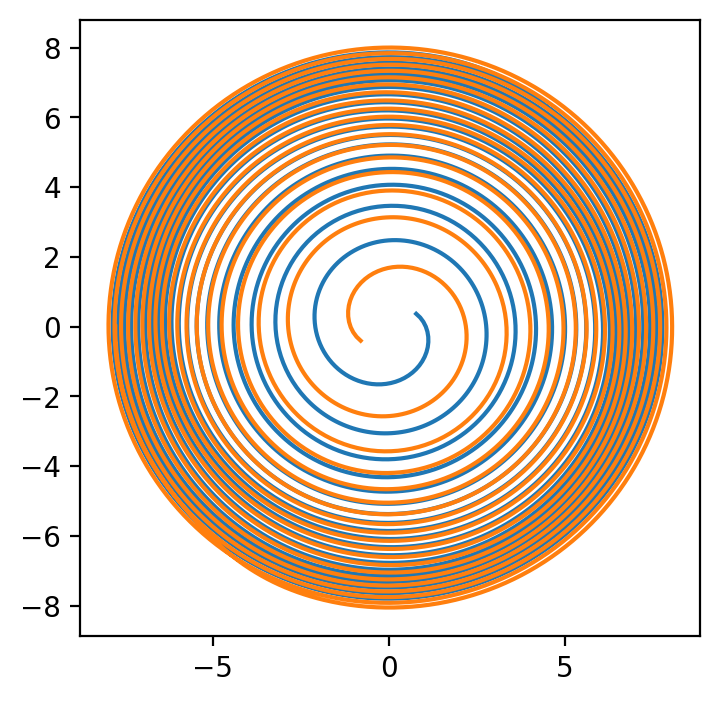

In [137]:
plt.figure(figsize=(4, 4))
plt.plot(horizons.A.coord_center_inertial[:, 0], horizons.A.coord_center_inertial[:, 1])
plt.plot(horizons.B.coord_center_inertial[:, 0], horizons.B.coord_center_inertial[:, 1])

/Users/nlf/.virtualenvs/scientific/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


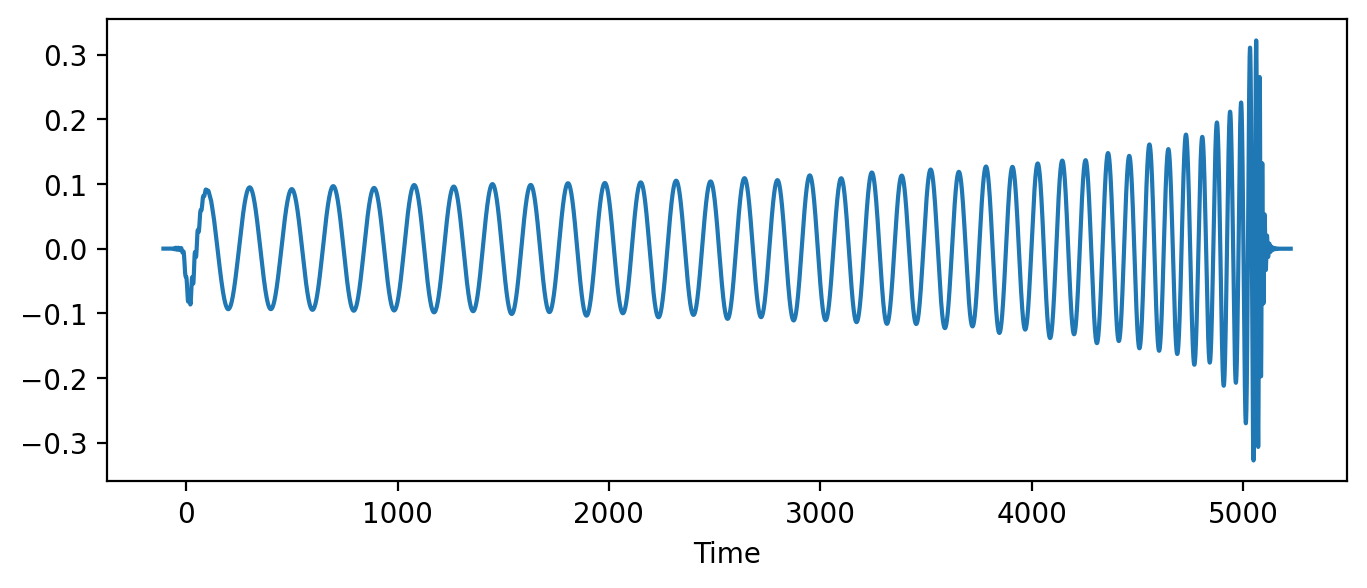

In [136]:
plt.figure(figsize=(8, 3))
plt.plot(waveform.t, waveform[:, waveform.index(2, 2)])
plt.xlabel("Time");

In [160]:
def interpolate(waveform, phase, wigner):
    mode_data = np.zeros((len(phase), wigner.Ysize), dtype=complex)
    for mode in spherical.LM_range(wigner.ell_min, wigner.ell_max):
        mode_data[:, spherical.LM_index(*mode, wigner.ell_min)] = np.interp(
            phase,
            waveform.t,
            waveform[:, waveform.index(*mode)],
            left=0.,
            right=0.)
    return mode_data


def evaluate(mode_data, angles, wigner):
    sYlm = np.empty(wigner.Ysize, dtype=complex)
    h = np.empty(len(angles), dtype=complex)
    for i in range(len(h)):
        wigner.sYlm(waveform.spin_weight, angles[i], out=sYlm)
        h[i] = np.dot(mode_data[i], sYlm)
    return h


def waveform_to_volume(waveform,
                       time,
                       domain_radius,
                       radial_scale,
                       inner_radius,
                       resolution,
                       scale_by_one_over_r,
                       ell_max=None,
                       ell_min=None):
    """Evaluate the waveform at a retarded time

    Parameters
    ----------
    waveform: An SXS waveform
    time: A time to visualize. The center of the visualization will show the
      GW radiation at this time, and locations away from the center will show
      the GW radiation at earlier times. Choose by plotting the waveform.
    domain_radius: The radial size of the domain to visualize. Change this
      parameter or 'radial_scale' to adjust the number of GW cycles that are
      shown.
    radial_scale: Increase to show more GW cycles.
    inner_radius: Set the GW strain to zero within this radius.
    resolution: Increase for higher resolution, but computation takes longer.
      This parameter corresponds to the number of sample points per dimension.
    scale_by_one_over_r: Set to 'False' to remove the 1/r scaling of the GW
      strain.
    ell_max, ell_min: The range of waveform modes.

    Returns
    -------
    x, y, h: Coordinates and complex GW strain
    """
    x_space = np.linspace(-domain_radius, domain_radius, resolution)
    y_space = np.linspace(-domain_radius, domain_radius, resolution)
    x, y = map(lambda arr: arr.flatten(order='F'),
               np.meshgrid(x_space, y_space, indexing='ij'))
    r = np.sqrt(x**2 + y**2)
    phase = time - (r - inner_radius) * radial_scale
    angles = quaternionic.array.from_spherical_coordinates(
        np.zeros(x.shape), np.arctan2(y, x))

    if ell_min is None:
        ell_min = waveform.ell_min
    if ell_max is None:
        ell_max = waveform.ell_max
    wigner = spherical.Wigner(ell_max,
                              ell_min=ell_min,
                              mp_max=abs(waveform.spin_weight))

    mode_data = interpolate(waveform, phase, wigner)
    h = evaluate(mode_data, angles, wigner)

    h[r < inner_radius] = 0.
    if scale_by_one_over_r:
        h /= r

    shape = (resolution, resolution)
    return x.reshape(shape), y.reshape(shape), h.reshape(shape)

In [155]:
def get_horizon_mask(x, y, horizon, time, scale):
    x_horizon = np.interp(time, horizon.time, horizon.coord_center_inertial[:, 0])
    y_horizon = np.interp(time, horizon.time, horizon.coord_center_inertial[:, 1])
    m_horizon = np.interp(time, horizon.time, horizon.areal_mass)
    return np.sqrt((x - x_horizon)**2 + (y - y_horizon)**2) < m_horizon * scale

In [156]:
print("Merger is approx. at time:", waveform.max_norm_time())

Merger is approx. at time: 5072.420390545342


In [174]:
# time = 4500  # Inspiral
time = 5050  # Close to merger
# time = 5200  # Post-merger
x, y, h = waveform_to_volume(waveform,
                             time=time,
                             domain_radius=40,
                             radial_scale=8,
                             inner_radius=10,
                             resolution=400,
                             scale_by_one_over_r=True)

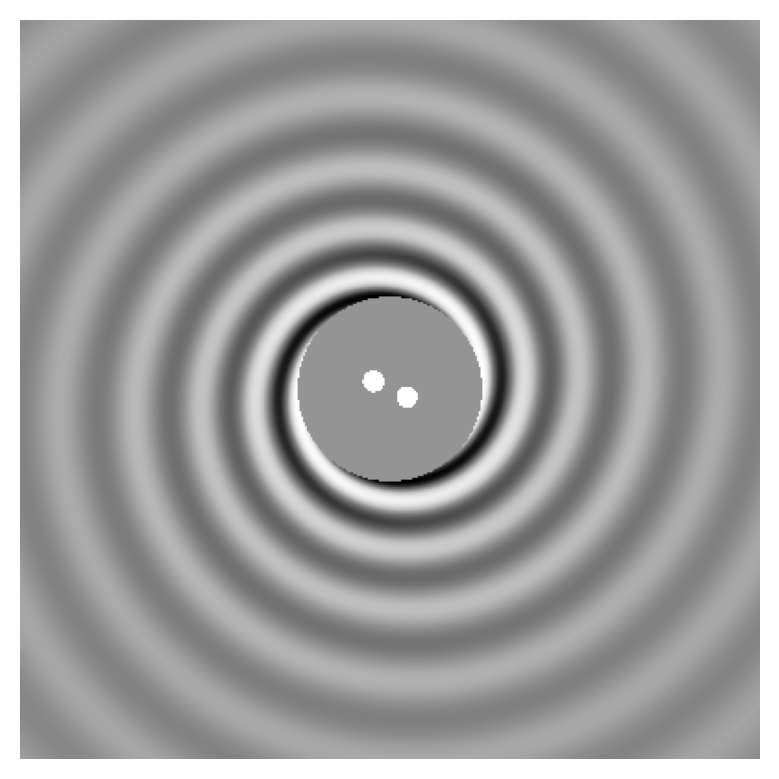

In [175]:
# Normalize and plot the GW strain
h_norm = np.max(np.abs(h))
topology = np.real(h) / h_norm
# Plot the black-hole horizons as "holes"
horizon_scale = 2.5 # Increase the size of the horizons
if time < waveform.max_norm_time():
    # Two black holes before merger
    topology[get_horizon_mask(x, y, horizons.A, time=time,
                            scale=horizon_scale)] = -1
    topology[get_horizon_mask(x, y, horizons.B, time=time,
                            scale=horizon_scale)] = -1
else:
    # One black hole after merger
    topology[get_horizon_mask(x, y, horizons.C, time=time,
                            scale=horizon_scale)] = -1
plt.imshow(topology, cmap='Greys')
plt.axis('off');